In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

import warnings
warnings.filterwarnings("ignore")

In [22]:
covid = pd.read_parquet('covidClean.parquet')

df = covid[["DEATH_DATE", "SYMPTOMS_DATE", "DIED"]]
df["DAYS"] = (df["DEATH_DATE"] - df["SYMPTOMS_DATE"]).dt.days

df = df[df["DAYS"] > 0]
df = df[df["DAYS"] < 90]
df = df.fillna(0)

print(df)

Text(0.5, 0, 'time $t$')

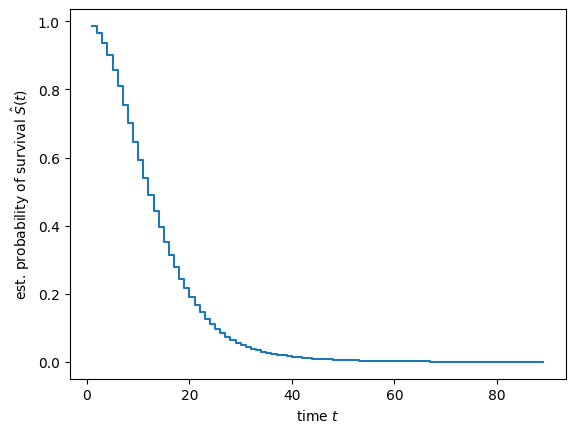

In [23]:
time, survival_prob = kaplan_meier_estimator(df["DIED"], df["DAYS"])

plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")